In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from utility.gen_dataset import gen_dataset

# Data Processing

- Need to generate 10 different response curves from kaustubh's simulation
- Store parameters in panda table

In [57]:
# original function
def get_true_quantile(r_true, quantile=0.5):
    i = np.arange(len(r_true))
    c = np.cumsum(r_true)
    q = np.searchsorted(c, quantile*c[-1])
    return np.where(c[q]/c[-1] == quantile, 0.5 * (i[q] + i[q+1]), i[q])

# wrapper function for getting all true edh bins
def get_all_true_quantlies(r_true, quantiles):
    bins = []
    for qnt in quantiles:
        bins.append(get_true_quantile(r_true, quantile=qnt))
    return bins

In [5]:
# test above
def oracle_edh(tr, n_edh):
    bins = tr.shape[-1]
    tr_cs = np.cumsum(tr)
    tr_sum = np.sum(tr)
    edh_bins = np.zeros((n_edh-1))
    for idx in range(edh_bins.shape[-1]):
        edh_bins[idx] = np.argmin(np.abs(tr_cs - tr_sum*(idx+1.0)/n_edh))
    return edh_bins+1

# bins, trs = gen_dataset(bins=16)
# oracle_bins = oracle_edh(trs, 16)
# quantiles = []
# for idx, bd in enumerate(bins):
#     quantiles.append(np.sum(trs[:int(bd)])/np.sum(trs)*100)
# quantile_bins = get_all_true_quantlies(trs, quantiles)
# print(oracle_bins-quantile_bins)

In [18]:
# generate gaussian and return necessary parameters
def gen_gauss(a, b, c, x_range):
    return a*np.exp(-(x_range - b)**2 / (2*c**2))

def get_true_gauss_params(height, width, ambient, depth, bins):
    gauss = gen_gauss(height, depth, width/2.355, np.arange(1000)) + ambient
    return {
        'height': height,
        'width': width,
        'ambient': ambient,
        'depth': depth,
        'edh_bds': oracle_edh(gauss, bins),
        'data_pts': gauss
    }

In [7]:
# generate 10 raw gaussian datasets w/ boundaries
# store a ground-truth and blind copy to a *.pkl file

# constants
BINS = 16
HEIGHT_RANGE = (10, 100)
PULSE_WIDTH_RANGE = (10, 50)
AMBIENT_RANGE = (10, 100)
DEPTH_RANGE = (50, 950)

SAMPLE_COUNT = 10

# generation code
rng = np.random.default_rng()
data = []
for i in range(SAMPLE_COUNT):
    height = rng.uniform(low=HEIGHT_RANGE[0], high=HEIGHT_RANGE[1])
    width = rng.uniform(low=PULSE_WIDTH_RANGE[0], high=PULSE_WIDTH_RANGE[1])
    ambient = rng.uniform(low=AMBIENT_RANGE[0], high=AMBIENT_RANGE[1])
    depth = rng.uniform(low=DEPTH_RANGE[0], high=DEPTH_RANGE[1])
    data.append(get_true_gauss_params(height, width, ambient, depth, BINS))
df = pd.DataFrame(data)
df.to_pickle('data/ground-truth.pkl')
df

,height,width,ambient,depth,edh_bds,data_pts
0,55.007167,47.585279,98.630431,329.667274,"[64.0, 129.0, 193.0, 257.0, 315.0, 359.0, 422....","[98.63043128857122, 98.63043128857122, 98.6304..."
1,85.017560,13.769359,89.409545,936.591276,"[63.0, 127.0, 190.0, 253.0, 317.0, 380.0, 444....","[89.4095453337022, 89.4095453337022, 89.409545..."
2,20.232404,21.553514,76.642929,557.750613,"[63.0, 126.0, 189.0, 252.0, 314.0, 377.0, 440....","[76.64292873259743, 76.64292873259743, 76.6429..."
3,25.126853,22.695689,63.906773,451.669879,"[63.0, 126.0, 189.0, 252.0, 315.0, 379.0, 441....","[63.90677317900293, 63.90677317900293, 63.9067..."
4,12.891194,36.834585,63.701006,146.575569,"[63.0, 125.0, 181.0, 244.0, 307.0, 370.0, 433....","[63.70100632935747, 63.70100632935747, 63.7010..."
5,35.975509,14.470107,61.178792,441.244261,"[63.0, 126.0, 189.0, 252.0, 315.0, 378.0, 439....","[61.17879170932148, 61.17879170932148, 61.1787..."
6,47.523546,41.892054,12.671871,513.233983,"[73.0, 146.0, 219.0, 292.0, 365.0, 438.0, 492....","[12.67187068626271, 12.67187068626271, 12.6718..."
7,14.113375,28.085374,93.551338,274.127372,"[63.0, 126.0, 188.0, 251.0, 309.0, 372.0, 435....","[93.55133760374012, 93.55133760374012, 93.5513..."
8,19.911947,49.003843,57.302682,670.485455,"[64.0, 127.0, 191.0, 255.0, 318.0, 382.0, 445....","[57.302682316069195, 57.302682316069195, 57.30..."
9,37.615219,19.191470,16.718096,787.194975,"[65.0, 131.0, 196.0, 261.0, 327.0, 392.0, 458....","[16.718095904275838, 16.718095904275838, 16.71..."


# Data Analysis

- first draw gaussian graphs to visually understand dataset
- start with Daphne's idea for estimation:
    - use params to generate a "best estimate" gaussian function of what the true gaussian should look like
    - use scipy optimize methods to best estimate the original gaussian
    - plug new gaussian into `oracle_bin()` to get bin counts
    - record rmse and optimize further

In [17]:
df = pd.read_pickle('data/ground-truth.pkl')

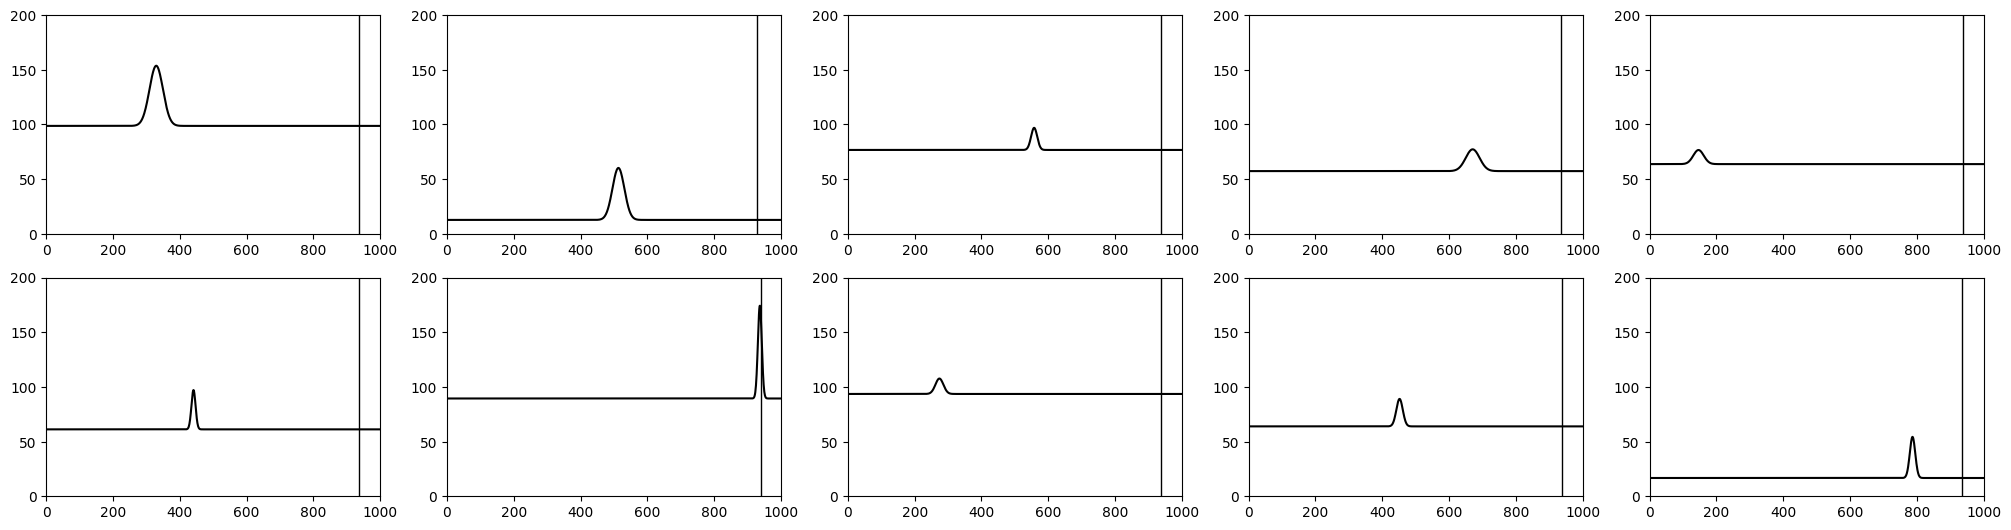

In [36]:
# functions for plotting
def binlvl(idx,len_):
    return int(math.log(len_+1,2) - math.log(math.gcd(idx+1, len_+1),2)) - 1

def plot_eqbins(ebins, ax_, lw = 1, ls='-', cmin = 0, cmax = -1):
    colors = ['r','g','b','k','y','c']
    for idx,e in enumerate(ebins):
        if (cmax!= -1) and ((e < cmin) or (e > cmax)):
            continue
    c = colors[binlvl(idx,len(ebins))]
    ax_.axvline(x = e, color = c, label = 'axvline - full height', linewidth = lw, linestyle=ls)

def plot_gaussian(x, y, edh_bins, ax):
    ax.plot(x, y, 'k-')
    plot_eqbins(edh_bins, ax)

gauss_data_set, edh_bin_set = df.data_pts, df.edh_bds
fig, axes = plt.subplots(2, 5, figsize=(25, 6.25))
for i in range(df.shape[0]):
    y_set, edh_bins = gauss_data_set[i], edh_bin_set[i]
    r, c = i % 2, i % 5
    ax = axes[r][c]
    ax.set_ylim(0, HEIGHT_RANGE[1]+100)
    ax.set_xlim(0, DEPTH_RANGE[1]+50)
    plot_gaussian(np.arange(len(y_set)), y_set, edh_bins, ax)
plt.show()

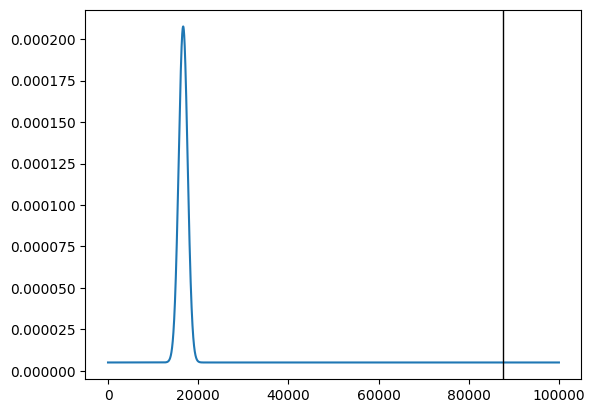

In [38]:
edh, trs = gen_dataset(bins=16)
plt.plot(trs)
plt.scatter(edh)

## Estimating a Gaussian
- There are a variety of different ways this could be done:
    - use least-squares to estimate params a, b, c
    - compute mean and standard deviation from EDH bins
    - probably a lot of other ways if I actually knew statistics
- Gen each and compare errors

[ 64. 129. 193. 257. 315. 359. 422. 486. 550. 614. 679. 743. 807. 871.
 936.] 98.63043128857122
495.0 267.03532849918315
[98.63211539 98.63212711 98.63213889 98.63215073 98.63216262 98.63217457
 98.63218658 98.63219864 98.63221077 98.63222295 98.63223519 98.63224749
 98.63225984 98.63227226 98.63228473 98.63229726 98.63230985 98.6323225
 98.63233521 98.63234797 98.6323608  98.63237368 98.63238662 98.63239962
 98.63241268 98.63242579 98.63243897 98.6324522  98.63246549 98.63247885
 98.63249226 98.63250573 98.63251925 98.63253284 98.63254648 98.63256019
 98.63257395 98.63258777 98.63260165 98.63261559 98.63262959 98.63264365
 98.63265776 98.63267193 98.63268617 98.63270046 98.63271481 98.63272921
 98.63274368 98.6327582  98.63277279 98.63278743 98.63280213 98.63281689
 98.6328317  98.63284658 98.63286151 98.6328765  98.63289155 98.63290665
 98.63292182 98.63293704 98.63295232 98.63296766 98.63298305 98.6329985
 98.63301401 98.63302958 98.6330452  98.63306089 98.63307662 98.63309242
 98.6

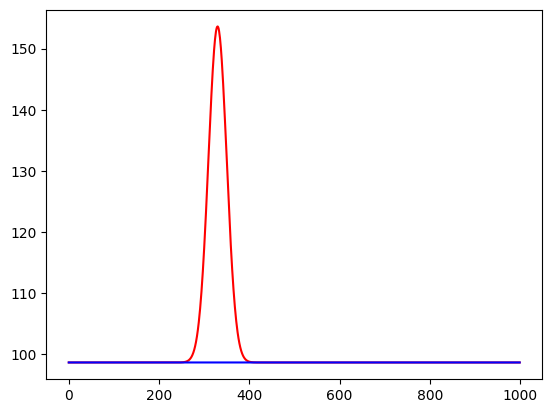

In [34]:
# generate gaussian using stdev and mean
def gen_gaussian_from_stats(mu, sigma, x_range):
    a = 1/sigma*math.sqrt(2*math.pi)
    b = mu
    c = sigma
    return gen_gauss(a, b, c, x_range)

edh_bins, ambient = df.edh_bds[0], df.ambient[0]
print(edh_bins, ambient)
mu = np.mean(edh_bins)
sigma = np.std(edh_bins)
print(mu, sigma)
x_range = np.arange(1000)
pred_y = gen_gaussian(mu, sigma, x_range) + ambient
print(pred_y)
plt.plot(x_range, df.data_pts[0], color='r')
plt.plot(x_range, pred_y, color='b')
plt.show()